In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../gsmvi//')
from gsm import GSM
from bbvi import ADVI, Scorenorm, Fishernorm
#####                                                                                                                                                         
from initializers import lbfgs_init

# sys.path.append('../utils/')
# from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from gsmvi.monitors import KLMonitor as Monitor



# BAM, BAM_lr

In [5]:
from ls_gsm import LS_GSM
from gsm import GSM
from gsmvi.monitors import KLMonitor
from gsmvi.bam_lrproject import BAM_lrproject



In [7]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples



D = 32
rank = 16
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
# alg = GSM(D, lp, lp_g)
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = LS_GSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit, covfit = alg.fit(key,  batch_size=16, niter=100, regf=lambda x: 100, monitor=monitor)

Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100


In [9]:
alg2 = BAM_lrproject(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit2, covfit2 = alg2.fit(key, rank=16, batch_size=16, n_project=256, niter=100, regf=lambda x: 100, monitor=monitor2)

Iteration 0 of 100
jit estep
jit mstep
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100


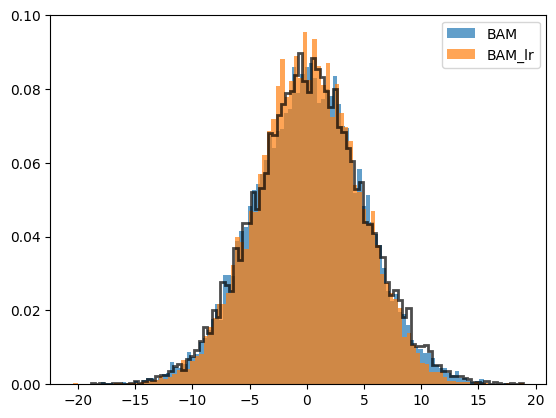

In [12]:
plt.hist(np.random.multivariate_normal(meanfit, covfit, 10000)[..., 0], bins=100, density=True, alpha=0.7, label='BAM');
plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., 0], bins=100, density=True, alpha=0.7, label='BAM_lr');
plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');
plt.legend()

# Code development below

# code copied
Code taken from https://github.com/je-suis-tm/machine-learning/blob/master/factor%20analysis.ipynb

In [326]:
from numpyro.distributions import Normal

In [327]:
#get latent variables z
#andrew ng didnt teach us how to get the latent
#we have to borrow ideas from sklearn even though we dont know why
#alternatively
#x=miu+lambda_@z+epsilon
#z=inverse(lambda_)@(x-miu-epsilon)
#but this is incorrect
#as we dont know epsilon
#we can only assume its zero
#z=np.linalg.pinv(lambda_)@(data-miu).T
@jit
def get_latent(data,miu,lambda_,psi):
    
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    weighted_psi = lambda_.T@psi_inv
    cov_z = jnp.linalg.inv(jnp.identity(lambda_.shape[1])+weighted_psi@lambda_)
    z= (data - miu)@(weighted_psi).T@cov_z
    
    return z


#pdf of multivariate gaussian
#equivalent to scipy.stats.multivariate_normal(miu,sigma).pdf(data)
def multivariate_gaussian(data,miu,sigma):
    
    numerator=np.exp(-0.5*(data-miu)@np.linalg.inv(sigma)@(data-miu).T)
    denominator=(2*np.pi)**(data.shape[1]/2)*np.linalg.det(sigma)**0.5

    return np.diagonal(numerator/denominator)


#unlike gmm, only p(x|z) depends on the params
#thus the computation can be simplified
#although we have one more step of computing z
# def get_lower_bound(data,miu,lambda_,psi):
    
#     #transform x
#     z=get_latent(data,miu,lambda_,psi)

#     #logarithm multivariate gaussian
#     logpdf=np.log(multivariate_gaussian(data-(lambda_@z.T).T,miu,psi))    
#     lower_bound=sum(logpdf)
    
#     return lower_bound


@jit
def get_lower_bound(data, mu, llambda, psi):
    
    z = get_latent(data, mu, llambda, psi)    
    loc = (llambda@z.T).T
    scale = jnp.diag(psi)**0.5
    logpdf = Normal(loc, scale).log_prob(data)
    lower_bound = logpdf.sum()
    
    return lower_bound
    

In [324]:
# #e step
# #use lambda_ and psi to update conditional miu and sigma
# def e_step(data,miu,lambda_,psi):
    
#     #denote beta
#     beta=lambda_.T@np.linalg.inv(lambda_@lambda_.T+psi)

#     #compute conditional params
#     miu_z_given_x=beta@(data-miu).T
#     sigma_z_given_x=np.identity(lambda_.shape[1])-beta@lambda_
    
#     return miu_z_given_x,sigma_z_given_x

# #m step
# #use conditional miu and sigma to update lambda_,psi
# def m_step(data,miu,miu_z_given_x,sigma_z_given_x):

#     #equation 8 in stanford material
#     lambda_=(data-miu).T@miu_z_given_x.T@np.linalg.inv(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)

#     #last equation
#     phi=(data.T@data-2*data.T@miu_z_given_x.T@lambda_.T+ \
#          lambda_@(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)@lambda_.T)/data.shape[0]
    
#     #take diagonal
#     psi=np.diag(np.diag(phi))
    
#     return lambda_,psi




In [7]:
# #using mle for training
# def training(data,num_of_latents,
#              tolerance=0.001,num_of_itr=50,diagnosis=False):
        
#     #get dimensions
#     num_of_features=data.shape[1]
    
#     #initialize
#     lower_bound_old=None
#     lower_bound=None
#     counter=0
    
#     #miu is the unconditional mean
#     miu=data.mean(axis=0)    
    
#     #lambda_ is the coefficient of the latent variables
#     #use principal components to initialize
#     #this approach improves the performance (Barber 2012)
#     _,eigvecs=np.linalg.eig((data-miu).T@(data-miu)/data.shape[0])
#     lambda_=eigvecs[:,:num_of_latents]

#     #psi is the covariance matrix of noise, a diagonal matrix
#     #use the diagonal of covariance matrix to initialize
#     psi=np.diag(np.diag((data-miu).T@(data-miu)/data.shape[0]))  

#     #cap the maximum number of iterations
#     while counter<num_of_itr:
        
#         #e step
#         miu_z_given_x,sigma_z_given_x=e_step(data,miu,lambda_,psi)
            
#         #m step
#         lambda_,psi=m_step(data,miu,
#                            miu_z_given_x,
#                            sigma_z_given_x)
            
#         #use lower bound to determine if converged
#         lower_bound_old=lower_bound
#         lower_bound=get_lower_bound(data,miu,lambda_,psi)
            
#         if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
#             if diagnosis:
#                 print(f'{counter} iterations to reach convergence\n')
#             return miu_z_given_x,sigma_z_given_x,lambda_,psi
            
#         counter+=1
    
#     if diagnosis:
#         print(f'{counter} iterations to reach convergence\n')
        
#     return miu_z_given_x,sigma_z_given_x,lambda_,psi

# num_of_latents=2
# #load data
# iris=sklearn.datasets.load_iris()
# miu_z_given_x,sigma_z_given_x,lambda_,psi=training(iris.data,
#                                                    num_of_latents,
#                                                    diagnosis=True)
# clf=skl_fa(iris.data,num_of_latents)
# #both lambda and psi seem to be different from the result of sklearn
# print(lambda_)
# print(clf.components_.T)
# print(psi)
# print(np.diag(clf.noise_variance_))


# Lawrence's paper

https://cseweb.ucsd.edu/~saul/papers/fa_ieee99.pdf

In [407]:
# def estep(x, mu, llambda, psi):

#     D = mu.size
#     r = llambda.shape[1]
#     psi_inv = np.diag(np.diagonal(psi)**-1)
#     alpha = llambda.T@psi_inv    
#     beta = np.linalg.pinv(np.identity(r) + alpha@llambda)
#     e_zmu_x = (beta@alpha)@(x-mu).T
#     e_zsigma_x = beta
#     return e_zmu_x.T, e_zsigma_x

# def mstep(x, mu, llambda, psi, e_zmu_x, e_zsigma_x):
    
#     N, D, r = x.shape[0], x.shape[1], llambda.shape[1]    
#     delx = x - x.mean(axis=0)
#     delz = e_zmu_x  - e_zmu_x.mean(axis=0)

#     zcov = np.zeros_like(e_zsigma_x)
#     xcov = np.zeros((D, r))
#     for z in delz:
#         zcov += np.outer(z, z)/N
#     for a, b in zip(delx, delz):
#         xcov += np.outer(a, b)/N
    
#     llambda_update = xcov @ np.linalg.pinv(e_zsigma_x + zcov)
#     mu_update = (x - (llambda_update@e_zmu_x.T).T).mean(axis=0)
#     psi_update = np.diag(((delx - (llambda_update@delz.T).T)**2).mean(axis=0) + np.diagonal(llambda_update@e_zsigma_x@llambda_update.T))
    
#     return mu_update, llambda_update, psi_update



@jit
def estep(x, mu, llambda, psi):
    print('jit estep')
    D = mu.size
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.inv(np.identity(r) + alpha@llambda)
    e_zmu_x = (beta@alpha)@(x-mu).T
    e_zsigma_x = beta
    return e_zmu_x.T, e_zsigma_x

@jit
def mstep(x, mu, llambda, psi, e_zmu_x, e_zsigma_x):
    print('jit mstep')
    N, D, r = x.shape[0], x.shape[1], llambda.shape[1]    
    delx = x - x.mean(axis=0)
    delz = e_zmu_x  - e_zmu_x.mean(axis=0)

    zcov = jnp.zeros_like(e_zsigma_x)
    xcov = jnp.zeros((D, r))
    # for z in delz:
    #     zcov += jnp.outer(z, z)/N
    # for a, b in zip(delx, delz):
    #     xcov += jnp.outer(a, b)/N
    ## vamp will blow up memory here, need running average
    zcov = jnp.mean(jax.vmap(jnp.outer, in_axes=[0, 0])(delz, delz), axis=0)
    xcov = jnp.mean(jax.vmap(jnp.outer, in_axes=[0, 0])(delx, delz), axis=0)
    
    llambda_update = xcov @ jnp.linalg.inv(e_zsigma_x + zcov)
    mu_update = (x - (llambda_update@e_zmu_x.T).T).mean(axis=0)
    psi_update = jnp.diag(((delx - (llambda_update@delz.T).T)**2).mean(axis=0) + jnp.diagonal(llambda_update@e_zsigma_x@llambda_update.T))
    
    return mu_update, llambda_update, psi_update


In [399]:
# #using mle for training
# def training2(data, num_of_latents,
#              tolerance=0.001,num_of_itr=100, diagnosis=False):
        
#     #get dimensions
#     D=data.shape[1]
#     counter=0
#     mu = data.mean(axis=0)    
#     _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
#     llambda = eigvecs[:, :num_of_latents]
#     psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  
#     while counter < num_of_itr:
        
#         e_zmu_x, e_zsigma_x = estep_lawrence(data, mu, llambda, psi)
#         mu, llambda, psi = mstep_lawrence(data, mu, llambda, psi, e_zmu_x, e_zsigma_x)
#         counter+=1
    

# mux2, llambda2, psi2 = training2(x, num_of_latents, diagnosis=True)


In [404]:
#using mle for training
def fit_lr_gaussian(data, num_of_latents,
                 tolerance=0.001,num_of_itr=100, diagnosis=False, 
                 mu=None, llambda=None, psi=None):
        
    #get dimensions
    num_of_features=data.shape[1]
    
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    
    #miu is the unconditional mean
    if mu is None:
        mu = data.mean(axis=0)    
    
    #lambda_ is the coefficient of the latent variables
    #use principal components to initialize
    #this approach improves the performance (Barber 2012)
    if llambda is None:
        _, eigvecs = np.linalg.eig((data-mu).T@(data-mu)/data.shape[0])
        llambda = eigvecs[:, :num_of_latents]
    
    #psi is the covariance matrix of noise, a diagonal matrix
    #use the diagonal of covariance matrix to initialize
    if psi is None:
        psi = np.diag(np.diag((data - mu).T@(data - mu)/data.shape[0]))  

    #cap the maximum number of iterations
    while counter < num_of_itr:
        
        e_zmu_x, e_zsigma_x = estep(data, mu, llambda, psi)
        mu, llambda, psi = mstep(data, mu, llambda, psi, e_zmu_x, e_zsigma_x)
            
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        lower_bound=get_lower_bound(data, mu, llambda, psi)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi
            
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi

## Gaussian example to check projection

In [561]:
D = 32
r = 8
L = np.random.normal(0, 1, D*r).reshape(D, r)
diag =  np.diag(np.random.normal(1, 1e-2, D))
cov = L@L.T + diag
mu = np.random.uniform(1, 1., D)
x = np.random.multivariate_normal(mu, cov, 100)


In [562]:
num_of_latents = r
mux, llambda, psi = fit_lr_gaussian(x, num_of_latents, diagnosis=True, num_of_itr=100, tolerance=1e-3)
covx = llambda@llambda.T + psi

7 iterations to reach convergence



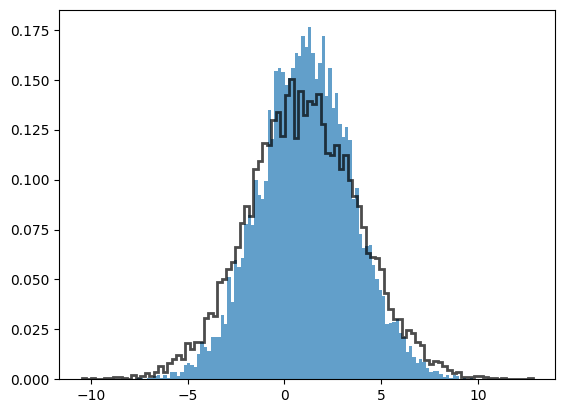

In [563]:
i = 0
plt.hist(np.random.multivariate_normal(mu, cov, 10000)[..., i], alpha=0.7, density=True, bins=100, histtype='step', lw=2, color='k');
plt.hist(np.random.multivariate_normal(mux, covx, 10000)[..., i], alpha=0.7, density=True, bins=100);

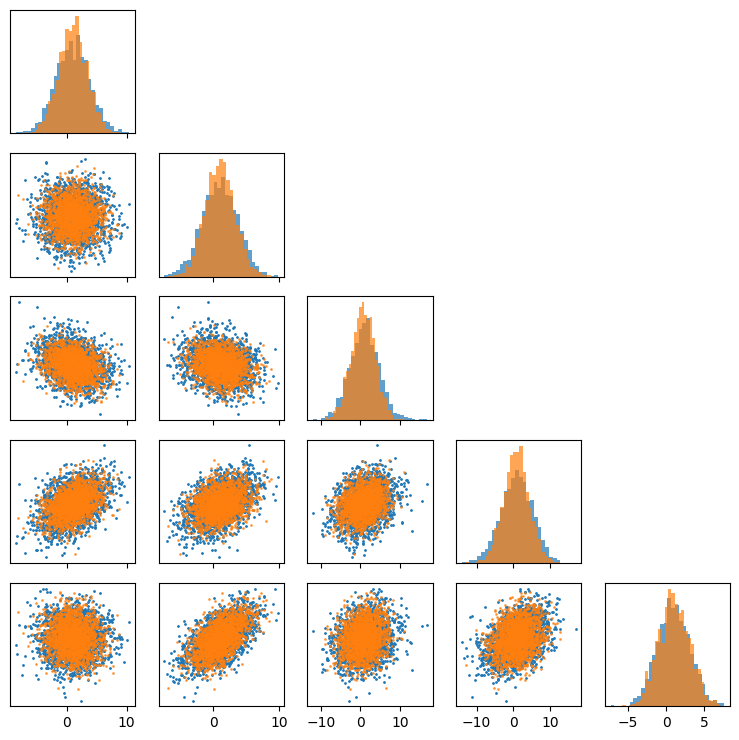

In [564]:
dplot = min(D, 5)
s = np.random.multivariate_normal(mu, cov, 2000)
s2 = np.random.multivariate_normal(mux, covx, 2000)

fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30);
            ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30);
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2)
            ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()


# BAM projection

In [21]:
from ls_gsm import LS_GSM
from gsm import GSM
from gsmvi.monitors import KLMonitor
from gsmvi.bam_lrproject import BAM_lrproject



In [ ]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples



D = 32
rank = 16
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)


In [22]:
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


# alg = GSM(D, lp, lp_g)
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = LS_GSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit, covfit = alg.fit(key,  batch_size=16, niter=100, regf=lambda x: 100, monitor=monitor)

Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100


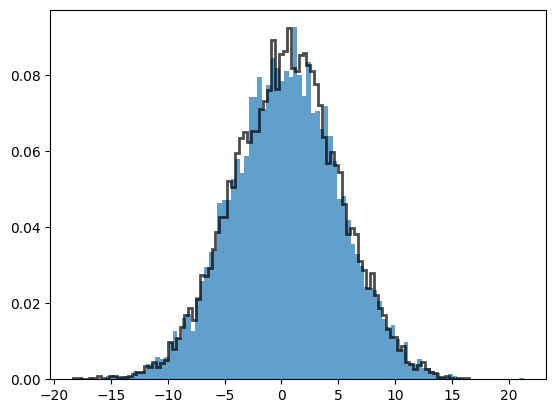

In [23]:
plt.hist(np.random.multivariate_normal(meanfit, covfit, 10000)[..., 0], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


In [24]:
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


alg2 = BAM_lrproject(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
meanfit2, covfit2 = alg2.fit(key, rank=16, batch_size=16, n_project=256, niter=100, regf=lambda x: 100, monitor=monitor2)

Iteration 0 of 100
jit estep
jit mstep
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100
Iteration 100 of 100


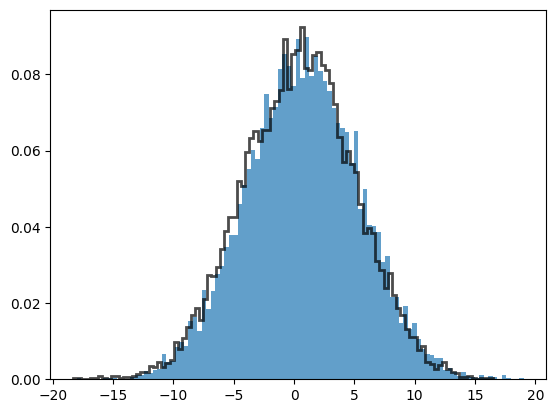

In [26]:
plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., 0], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., 0], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


## low rank fit function 

In [688]:

def _check_goodness(cov):
    is_good = False
    try:
        if (np.isnan(np.linalg.cholesky(cov))).any():
            nan_update.append(j)
        else:
            is_good = True
        return is_good
    except:
        return is_good



In [707]:
from ls_gsm import ls_gsm_lowrank_update

def low_rank_fit(key, D, lp, lp_g, rank, mean=None, cov=None, batch_size=16, 
                 niter=1000, nprint=10, regf=lambda x: 100, retries=10, jitter=1e-6, monitor=None):


    if mean is None:
        mean = jnp.zeros(D)
    if cov is None:
        cov = jnp.identity(D)

    mean_lr, llambda, psi = None, None, None
    nevals = 0 
    update_function = jit(ls_gsm_lowrank_update)

    for i in range(niter + 1):
        if (i%(niter//nprint) == 0):
            print(f'Iteration {i} of {niter}')

        if monitor is not None:
            if (i%monitor.checkpoint) == 0:
                monitor(i, [mean, cov], lp, key, nevals=nevals)
                nevals = 0

        # Can generate samples from jax distribution (commented below), but using numpy is faster                                                         
        j = 0
        while True:         # Sometimes run crashes due to a bad sample. Avoid that by re-trying.                                                         
            try:
                key, key_sample = random.split(key, 2)
                np.random.seed(key_sample[0])
                samples = np.random.multivariate_normal(mean=mean, cov=cov, size=batch_size)
                vs = lp_g(samples)
                nevals += batch_size
                reg = regf(i)
                mean_new, cov_new = update_function(samples, vs, mean, cov, reg)
                cov_new += np.eye(D) * jitter # jitter covariance matrix                                                                             
                cov_new = (cov_new + cov_new.T)/2.
                break
            except Exception as e:
                if j < retries :
                    j += 1
                    print(f"Failed with exception {e}")
                    print(f"Trying again {j} of {retries}")
                else : raise e

        is_good = _check_goodness(cov_new)
        if is_good:
            mean, cov = mean_new, cov_new
        else:
            if verbose: print("Bad update for covariance matrix. Revert")
            
        x = np.random.multivariate_normal(mean, cov, 256)
        if psi is None: 
            psi = jnp.diag(jnp.diag(cov))
        if llambda is None: 
            llambda = np.linalg.eigh(cov)[1][:, :rank]
            # llambda = np.linalg.svd(cov)[0][:rank, :].T
        _, llambda, psi = fit_lr_gaussian(x, rank, diagnosis=False,
                                             mu=mean, llambda=llambda, psi=psi, num_of_itr=200)
        cov = llambda@llambda.T + psi
        
      
    return mean, cov#, mean2, cov2


rank2 = int(rank)
ranklr = int(rank//2)
monitor2 = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
monitorlr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
meanfit2, covfit2 = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=rank2, 
                                 niter=100, monitor=monitor2, batch_size=min(D-1, 16), nprint=5)
meanfitlr, covfitlr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=ranklr, 
                                   niter=100, monitor=monitorlr, batch_size=min(D-1, 16), nprint=5)


Iteration 0 of 100
Iteration 20 of 100
Iteration 40 of 100
Iteration 60 of 100
Iteration 80 of 100



KeyboardInterrupt



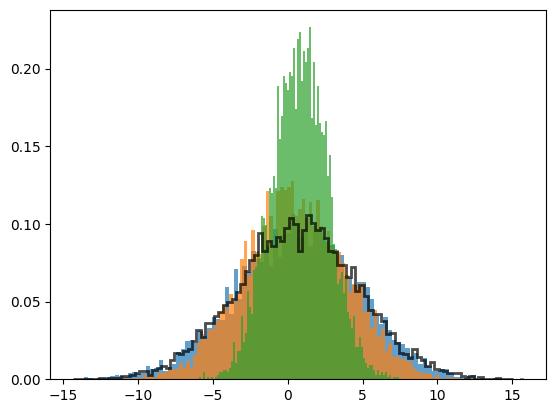

In [681]:
i = 3
plt.hist(np.random.multivariate_normal(meanfit, covfit, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(np.random.multivariate_normal(meanfitlr, covfitlr, 5000)[..., i], bins=100, density=True, alpha=0.7);
plt.hist(ref_samples[..., i], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');


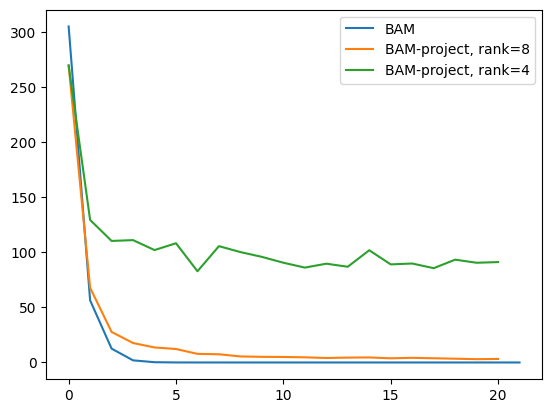

In [682]:
plt.plot(monitor.fkl, label='BAM')
plt.plot(monitor2.fkl, label=f'BAM-project, rank={rank2}')
plt.plot(monitorlr.fkl, label=f'BAM-project, rank={ranklr}')
# plt.loglog()
plt.legend()

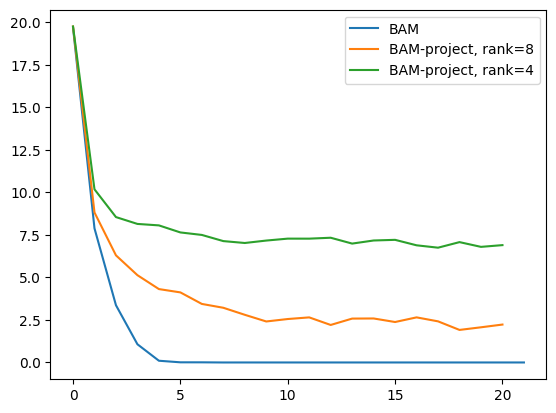

In [683]:
plt.plot(monitor.rkl, label='BAM')
plt.plot(monitor2.rkl, label=f'BAM-project, rank={rank2}')
plt.plot(monitorlr.rkl, label=f'BAM-project, rank={ranklr}')
# plt.loglog()
plt.legend()

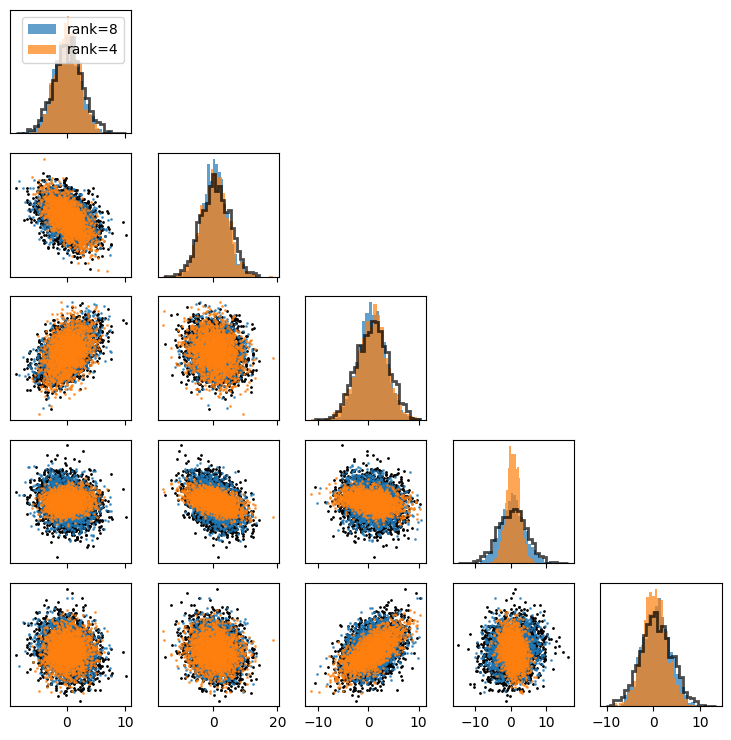

In [684]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30, label=f"rank={rank2}");
            ax[i, i].hist(s3[..., i], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
            ax[j, i].plot(s3[..., i], s3[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

In [708]:
fits = {}
ranks = [2, 4, 8, 12, 16, 20, 32]
for r in ranks:
    print(r)
    monitorr = KLMonitor(batch_size=128, ref_samples=ref_samples, checkpoint=5)
    meanfitr, covfitr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=r, 
                                     niter=100, monitor=monitorr, batch_size=min(D-1, 16), nprint=2)
    fits[r] = [meanfitr, covfitr, monitorr]
    
# mean2, cov2, mean2lr, cov2lr = low_rank_fit(key, D, lp_vmap, lp_g_vmap, rank=D, niter=10)

2
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100
4
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100
8
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100
12
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100
16
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100
20
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100
32
Iteration 0 of 100
Iteration 50 of 100
Iteration 100 of 100


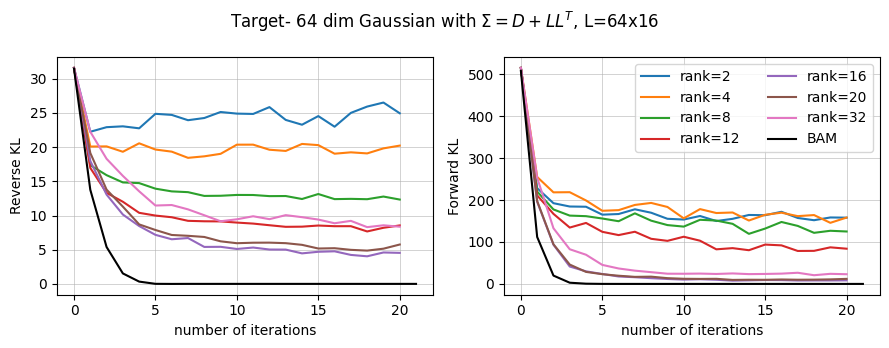

In [729]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))

for r in ranks:
    ax[0].plot(fits[r][-1].rkl, label=f'rank={r}')
    ax[1].plot(fits[r][-1].fkl, label=f'rank={r}')

ax[0].plot(monitor.rkl, color='k')
ax[1].plot(monitor.fkl, color='k', label='BAM')
ax[1].legend(ncol=2)
for axis in ax:
    axis.grid(lw=0.4)
    axis.set_xlabel('number of iterations')
ax[0].set_ylabel('Reverse KL')
ax[1].set_ylabel('Forward KL')
plt.suptitle(f'Target- {D} dim Gaussian with $\Sigma=D+LL^T$, L={D}x{rank}')
plt.tight_layout()


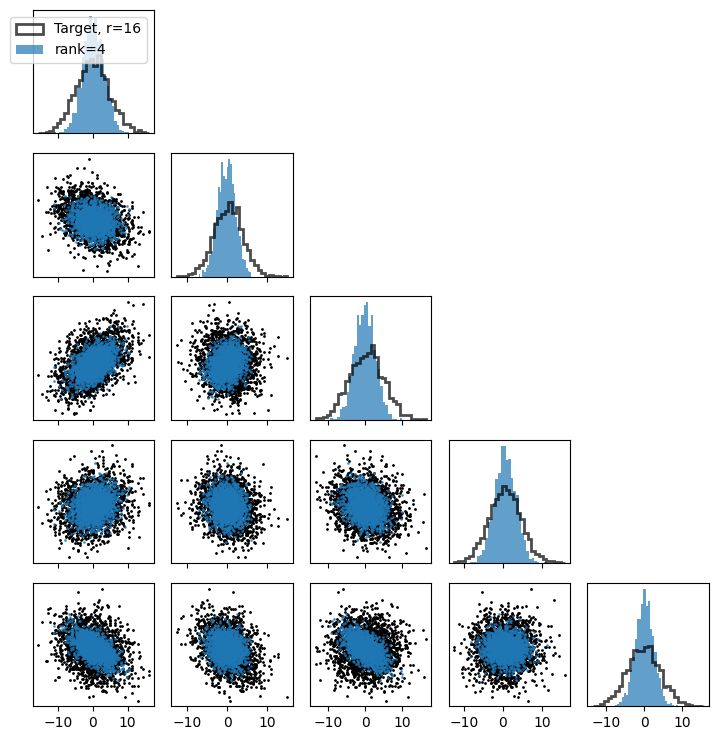

In [742]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)

rplot = [4]

ss = []
for r in rplot:
    meanfitr, covfitr = fits[r][:2]
    ss.append(np.random.multivariate_normal(meanfitr, covfitr, 2000))

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2, 
                          label=f'Target, r={rank}');
            for iss, s2 in enumerate(ss):
                ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30, label=f"rank={rplot[iss]}");
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
            for iss, s2 in enumerate(ss):
                ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

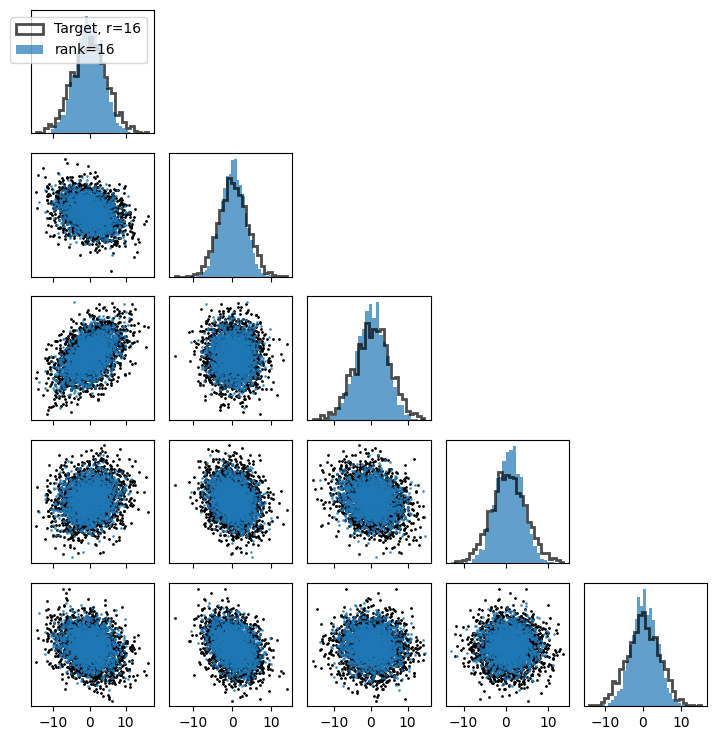

In [741]:
s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)

rplot = [16]

ss = []
for r in rplot:
    meanfitr, covfitr = fits[r][:2]
    ss.append(np.random.multivariate_normal(meanfitr, covfitr, 2000))

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')

for i in range(dplot):
    for j in range(dplot):
        if i == j: 
            ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2, 
                          label=f'Target, r={rank}');
            for iss, s2 in enumerate(ss):
                ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=30, label=f"rank={rplot[iss]}");
        elif j > i:
            ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
            for iss, s2 in enumerate(ss):
                ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

In [539]:
# s = np.random.multivariate_normal(mean, cov, 2000)
# s2 = np.random.multivariate_normal(meanfit, covfit, 2000)
# s3 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# # s3 = np.random.multivariate_normal(meanfitlr, covfitlr, 2000)
# fig, ax = plt.subplots(D, D, figsize=(D*1.5, D*1.5))

# for i in range(D):
#     for j in range(D):
#         if i == j: 
#             ax[i, i].hist(s[..., i], alpha=0.7, density=True, bins=100, histtype='step', lw=2, color='k');
#             ax[i, i].hist(s2[..., i], alpha=0.7, density=True, bins=100, color='C0');
#             ax[i, i].hist(s3[..., i], alpha=0.7, density=True, bins=100, color='C1');
#         elif j > i:
#             ax[j, i].plot(s[..., i], s[..., j], '.', alpha=1., ms=2, color='k')
#             ax[j, i].plot(s2[..., i], s2[..., j], '.', alpha=0.7, ms=2, color='C0')
#             ax[j, i].plot(s3[..., i], s3[..., j], '.', alpha=0.7, ms=2, color='C1')
#         else: 
#             ax[j, i].set_axis_off()